# Pendulum

The state and control vectors $\textbf{x}$ and $\textbf{u}$ are defined as follows:

$$
\begin{equation*}
\textbf{x} = \begin{bmatrix}
    \theta & \dot{\theta}
    \end{bmatrix}
\end{equation*}
$$

$$
\begin{equation*}
\textbf{u} = \begin{bmatrix}
    \tau
    \end{bmatrix}
\end{equation*}
$$

The goal is to swing the pendulum upright:
$$
\begin{equation*}
\textbf{x}_{goal} = \begin{bmatrix}
    \pi & 0
    \end{bmatrix}
\end{equation*}
$$

**Note**: The force is constrained between $-2.5$ and $2.5$ Nm.

In [1]:
%matplotlib inline

In [2]:
from __future__ import print_function

In [3]:
import matplotlib.pyplot as plt

In [4]:
import pddp
import pddp.examples

In [5]:
import torch
import numpy as np

In [6]:
DT = 0.1  # Time step (s).
N = 40  # Horizon length.
RENDER = True  # Whether to render the environment or not.
H = 3 * N  # Episode length.
U_MAX = torch.tensor([2.5])  # Maximum action.
U_MIN = -U_MAX  # Minimum action.

# Disable uncertainty since we are dealing with known dynamics.
ENCODING = pddp.StateEncoding.IGNORE_UNCERTAINTY

In [7]:
cost = pddp.examples.pendulum.PendulumCost()
model = pddp.examples.pendulum.PendulumDynamicsModel(DT)
env = pddp.examples.pendulum.PendulumEnv(dt=DT, render=RENDER)

In [8]:
def plot(Z, U):
    t = np.arange(Z.shape[0]) * DT
    X = pddp.utils.encoding.decode_mean(Z, ENCODING).detach().numpy()
    U = U.detach().numpy()

    theta = np.unwrap(X[:, 0])  # Makes for smoother plots.
    theta_dot = X[:, 1]
    
    plt.figure()
    plt.plot(theta, theta_dot)
    plt.xlabel("Orientation (rad)")
    plt.ylabel("Angular velocity (rad/s)")
    plt.title("Orientation Phase Plot")

    plt.figure()
    plt.plot(t, theta)
    plt.xlabel("Time (s)")
    plt.ylabel("Orientation (rad)")
    plt.title("Orientation path")

    plt.figure()
    plt.plot(t, theta_dot)
    plt.xlabel("Time (s)")
    plt.ylabel("Angular velocity (rad / s)")
    plt.title("Angular velocity path")
    
    plt.figure()
    plt.plot(t[:-1], U)
    plt.xlabel("Time (s)")
    plt.ylabel("Torque (N m)")
    plt.title("Constrained action path")
    
    plt.figure()
    plt.plot(J_hist)
    plt.xlabel("Iteration")
    plt.ylabel("Total loss")
    plt.title("Loss path")

In [9]:
def on_iteration(iteration, state, Z, U, J_opt):
    J_opt = J_opt.detach().numpy()

    J_hist.append(J_opt)
    final_state = Z[-1].detach().numpy()
    final_state[0] = (final_state[0] + np.pi) % (2 * np.pi) - np.pi
    print("iteration", iteration + 1, state, J_opt, final_state)

In [10]:
controller = pddp.controllers.iLQRController(env, model, cost)

In [11]:
U = torch.randn(N, model.action_size)

In [12]:
J_hist = []
controller.eval()
Z, U, state = controller.fit(U, encoding=ENCODING, n_iterations=1,
                             on_iteration=on_iteration, u_min=U_MIN, u_max=U_MAX)

iteration 1 iLQRState.ACCEPTED 451.5284 [ 2.6678524 -0.8067384]



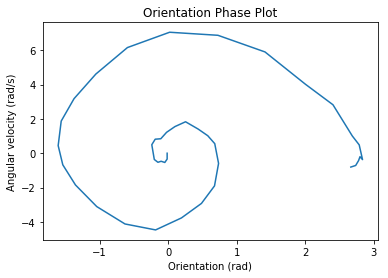

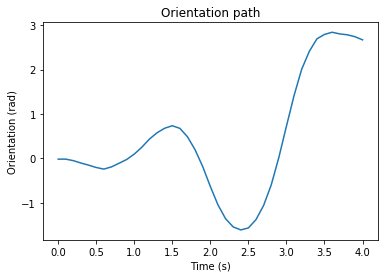

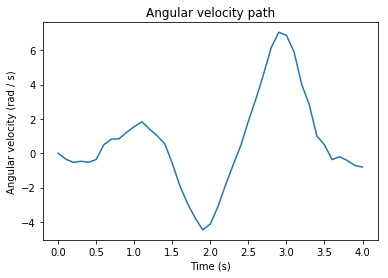

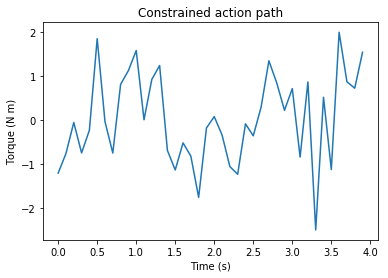

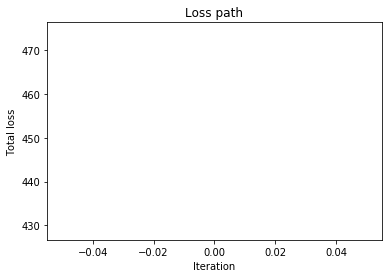

In [13]:
plot(Z, U)

In [14]:
if RENDER:
    # Wait for user interaction before visualizing. 
    _ = input("Press ENTER to continue")

Press ENTER to continue


In [15]:
env.reset()
Z = torch.empty(H + 1, Z.shape[-1])
U = torch.empty(H, model.action_size)
Z[0] = env.get_state().encode(ENCODING)
for i in range(H):
    U[i] = controller(Z[i], i, ENCODING, mpc=True, u_min=U_MIN, u_max=U_MAX, on_iteration=on_iteration)
    env.apply(U[i])
    Z[i + 1] = env.get_state().encode(ENCODING)

iteration 1 iLQRState.ACCEPTED 332.046 [ 2.8472664  -0.10962133]
iteration 2 iLQRState.ACCEPTED 290.42886 [ 2.8209863  -0.21247117]
iteration 3 iLQRState.ACCEPTED 228.95325 [2.5555449  0.06827271]
iteration 4 iLQRState.ACCEPTED 188.5222 [2.8326287 0.0149188]
iteration 5 iLQRState.ACCEPTED 298.00885 [ 2.5937672 -1.0544652]
iteration 6 iLQRState.ACCEPTED 179.711 [2.831763   0.10353419]
iteration 7 iLQRState.ACCEPTED 190.19087 [2.730406   0.39487487]
iteration 8 iLQRState.ACCEPTED 165.22856 [2.984711   0.01281035]
iteration 9 iLQRState.ACCEPTED 238.57907 [ 2.8289788  -0.85209644]
iteration 10 iLQRState.ACCEPTED 175.85922 [2.9608517 0.3618868]
iteration 11 iLQRState.ACCEPTED 223.76968 [2.822966   0.77409124]
iteration 12 iLQRState.ACCEPTED 157.88422 [3.0287273  0.01008964]
iteration 13 iLQRState.ACCEPTED 154.75775 [3.0628595e+00 2.2211969e-03]
iteration 14 iLQRState.ACCEPTED 153.19131 [3.0748034e+00 1.8597543e-03]
iteration 15 iLQRState.ACCEPTED 158.49367 [ 3.0515134  -0.24409953]
iteratio

iteration 114 iLQRState.ACCEPTED 3.1557967e-08 [ 3.1415925e+00 -5.9866022e-07]
iteration 115 iLQRState.ACCEPTED 2.3885125e-08 [-3.1415925e+00 -2.1022117e-10]
iteration 116 iLQRState.ACCEPTED 1.8027212e-08 [-3.1415925e+00  7.3985035e-08]
iteration 117 iLQRState.ACCEPTED 1.3633237e-08 [3.1415925e+00 1.2568029e-07]
iteration 118 iLQRState.ACCEPTED 1.03213065e-08 [ 3.1415925e+00 -3.1092560e-07]
iteration 119 iLQRState.ACCEPTED 7.860837e-09 [ 3.1415925e+00 -7.4681009e-07]
iteration 120 iLQRState.ACCEPTED 5.968527e-09 [-3.1415925e+00 -1.2884982e-09]


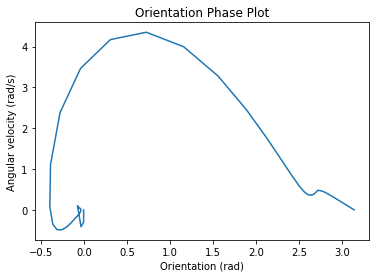

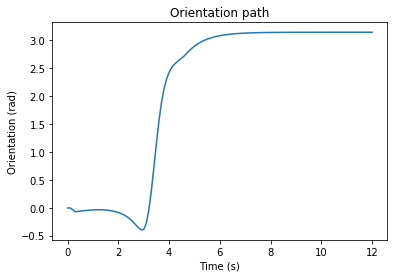

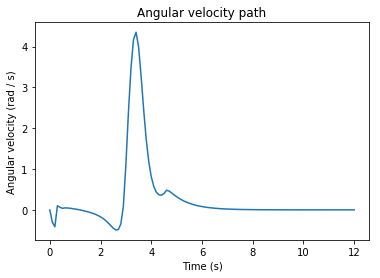

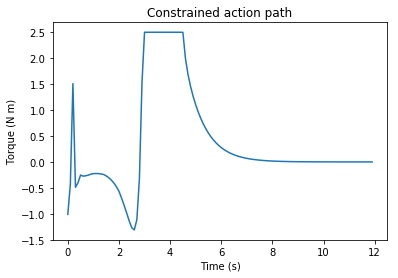

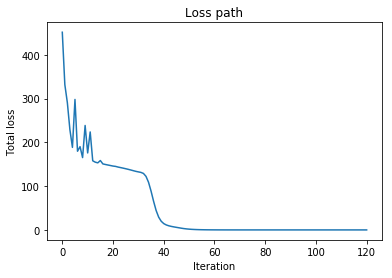

In [16]:
plot(Z, U)

In [17]:
if RENDER:
    # Wait for user interaction before visualizing. 
    _ = input("Press ENTER to continue")

Press ENTER to continue


In [18]:
for i in range(10):
    env.apply(torch.zeros(model.action_size))

In [19]:
env.close()